In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [0]:
#MODEL_NAME = 'RNN'
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

# Generate data

This is a toy example to predict a sequence with RNN.
In this example, Y is a sequence of 2D vectors (sin(x), cos(x)) for x in [-3.14, +3.14]

In practical applications, replace Y with the sequence to predict

In [0]:
# range of the data
X = np.linspace(-3.14 * 2, 3.14 * 2, 100)

In [4]:
#Y = np.array([(np.sin(x), np.cos(x)) for x in X])
Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
Y[:10]

array([[-0.17738876,  0.88215369],
       [ 0.19823561,  0.9646205 ],
       [ 0.30508959,  0.77088311],
       [ 0.35979678,  1.03686391],
       [ 0.46819006,  0.97763203],
       [ 0.48154243,  0.87230487],
       [ 0.78488903,  0.76122352],
       [ 0.77775696,  0.69645335],
       [ 0.78088911,  0.67583488],
       [ 1.00774039,  0.26649029]])

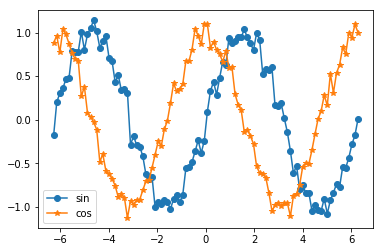

In [5]:
plt.plot(X, Y[:,0], label="sin", marker="o")
plt.plot(X, Y[:,1], label="cos", marker='*')
plt.legend()

# Convert numpy array to torch.Tensor

In [6]:
# convert Y into input tensors
#input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
input_tensor = torch.tensor(Y, dtype=torch.float32)
input_tensor.shape

torch.Size([100, 2])

In [7]:
# check input_tensor
input_tensor[:10]

tensor([[-0.1774,  0.8822],
        [ 0.1982,  0.9646],
        [ 0.3051,  0.7709],
        [ 0.3598,  1.0369],
        [ 0.4682,  0.9776],
        [ 0.4815,  0.8723],
        [ 0.7849,  0.7612],
        [ 0.7778,  0.6965],
        [ 0.7809,  0.6758],
        [ 1.0077,  0.2665]])

In [8]:
# make target_tensor by rotating input_tensor
# target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
target_tensor[:10]

tensor([[0.1982, 0.9646],
        [0.3051, 0.7709],
        [0.3598, 1.0369],
        [0.4682, 0.9776],
        [0.4815, 0.8723],
        [0.7849, 0.7612],
        [0.7778, 0.6965],
        [0.7809, 0.6758],
        [1.0077, 0.2665],
        [0.8025, 0.3776]])

In [9]:
# check the input and target tensors
print(torch.cat((input_tensor, target_tensor), 1)[:10])

tensor([[-0.1774,  0.8822,  0.1982,  0.9646],
        [ 0.1982,  0.9646,  0.3051,  0.7709],
        [ 0.3051,  0.7709,  0.3598,  1.0369],
        [ 0.3598,  1.0369,  0.4682,  0.9776],
        [ 0.4682,  0.9776,  0.4815,  0.8723],
        [ 0.4815,  0.8723,  0.7849,  0.7612],
        [ 0.7849,  0.7612,  0.7778,  0.6965],
        [ 0.7778,  0.6965,  0.7809,  0.6758],
        [ 0.7809,  0.6758,  1.0077,  0.2665],
        [ 1.0077,  0.2665,  0.8025,  0.3776]])


# Create RNN Class

In [0]:
import torch
import torch.nn as nn


# RNN to predict the sequence

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
#        print("shape = {}, {}".format(input.shape, hidden.shape))
#        print("input = {}".format(input))
#        print("hidden = {}".format(hidden))
      
        input_combined = torch.cat((input, hidden), -1)
        
#        print("combined = {}".format(input_combined))
        
        hidden = self.i2h(input_combined)
        output = self.h2o(hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
#rnn = RNN(2, 32, 2).to(DEVICE)
rnn = RNN(2, 32, 2)

# Train RNN

In [0]:
# select loss function
criterion = nn.MSELoss()

# learning rate
learning_rate = 0.0005

# set optimilzer
optimizer = torch.optim.Adam(rnn.parameters(), lr = learning_rate)

In [0]:
# define train function that trains for one step
def train(input_tensor, target_tensor):
#    hidden = rnn.initHidden().to(DEVICE)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_tensor.size(0)):
#        print("Input = {}, hidden = {}".format(input_tensor[i], hidden))
        output, hidden = rnn(input_tensor[i:i+1], hidden)
#        print("output = {}, target = {}".format(output, target_tensor[i:i+1]))
        l = criterion(output, target_tensor[i:i+1])
        loss += l

    loss.backward()

    optimizer.step()    
#    for p in rnn.parameters():
#        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_tensor.size(0)

### Note that pytorch modules inputs a batch rather than a vector!

In [14]:
# input_tensor[0].shape = torch.Size([2])
input_tensor[0]

tensor([-0.1774,  0.8822])

In [15]:
# input_tensor[0:1].shape = torch.Size([1, 2])
input_tensor[0:1]

tensor([[-0.1774,  0.8822]])

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def get_data(X):
#    X = np.linspace(-3.14 * 2, 3.14 * 2, 100)
    Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
#    input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
    input_tensor = torch.tensor(Y, dtype=torch.float32)
  
#    target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
    target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
    
    return input_tensor, target_tensor

In [0]:
# reset loss history
all_losses = []

In [39]:
n_iters = 5000
print_every = 200
plot_every = 200
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    input_tensor, target_tensor = get_data(X)
    output, loss = train(input_tensor, target_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 2s (200 4%) 0.0128
0m 5s (400 8%) 0.0131
0m 7s (600 12%) 0.0104
0m 11s (800 16%) 0.0107
0m 14s (1000 20%) 0.0115
0m 16s (1200 24%) 0.0098
0m 19s (1400 28%) 0.0100
0m 21s (1600 32%) 0.0106
0m 23s (1800 36%) 0.0122
0m 25s (2000 40%) 0.0123
0m 28s (2200 44%) 0.0102
0m 30s (2400 48%) 0.0137
0m 32s (2600 52%) 0.0090
0m 35s (2800 56%) 0.0101
0m 37s (3000 60%) 0.0084
0m 39s (3200 64%) 0.0099
0m 42s (3400 68%) 0.0116
0m 44s (3600 72%) 0.0099
0m 46s (3800 76%) 0.0094
0m 49s (4000 80%) 0.0120
0m 51s (4200 84%) 0.0105
0m 53s (4400 88%) 0.0107
0m 56s (4600 92%) 0.0092
0m 59s (4800 96%) 0.0107
1m 1s (5000 100%) 0.0119


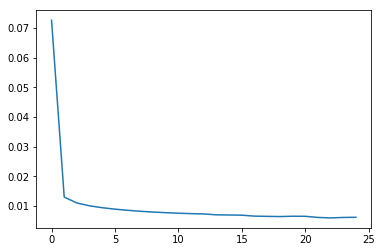

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [25]:
predict_tensor = torch.tensor([[np.sin(X[0]), np.cos(X[0])]])
predict_tensor

tensor([[0.0032, 1.0000]])

In [0]:
hidden = rnn.initHidden();

for i in range(1,len(X)):
#  print("input = {}".format(predict[-1:]))
#  print("hidden = {}".format(hidden))
  output, hidden = rnn(predict_tensor[-1:], hidden)
  predict_tensor = torch.cat((predict_tensor, output), 0)
#  print("predict = {}".format(predict))

In [27]:
predict_tensor[:10]

tensor([[0.0032, 1.0000],
        [0.1850, 0.9062],
        [0.2358, 0.8092],
        [0.3267, 0.9815],
        [0.4334, 0.9855],
        [0.5952, 0.9026],
        [0.7731, 0.7977],
        [0.7691, 0.7185],
        [0.8136, 0.6056],
        [0.9433, 0.4130]], grad_fn=<SliceBackward>)

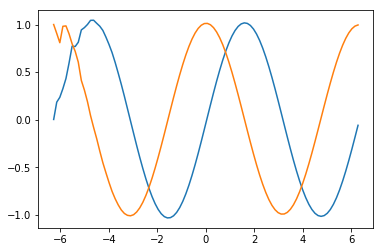

In [28]:
predict = predict_tensor.detach().numpy()
plt.plot (X, predict[:,0])
plt.plot (X, predict[:,1])